In [2]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import numpy as np
import os
import sys
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm


# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join("/home/eccoope", "pv-vision")
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join("/home/eccoope", "el_img_cracks_ec", "scripts")

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

# ojas_functions_dir = os.path.join(Path.home(), 'pvcracks/retrain/')
ojas_functions_dir = "/Users/ojas/Desktop/saj/SANDIA/pvcracks/retrain/"
sys.path.append(ojas_functions_dir)

from utils.unet_model import construct_unet
import functions

In [3]:
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
# root = Path('/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CornersIHDEANE/')
# root = Path('/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Norman_LineCorners/')
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LineCorners_With_Original/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_SunEdison_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/CWRU_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_SunEdison_and_Dupont_Mono/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/LBNL_Mono_Cells/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Combined_CWRU_LBNL_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/ASU_IHDEANE/"

root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_CWRU_SunEdison/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_LBNL/"

model_weight_paths = {
    "emma_retrained": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/retrained_pv-vision_model.pt",
    "original": "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/pv-vision_model.pt",
}

# weight_path = model_weight_paths["emma_retrained"]
weight_path = model_weight_paths["original"]

# checkpoint_name = "line_corners_og_weights_checkpoint"
# checkpoint_name = "CWRU_SunEdison_Mono"
# checkpoint_name = "CWRU_Dupont_Mono"
# checkpoint_name = "Combined_CWRU_SunEdison_and_Dupont_Mono"
# checkpoint_name = "LBNL_Mono_Cells"
# checkpoint_name = "Combined_CWRU_LBNL_ASU"

checkpoint_name = "Fresh_Combined_CWRU_LBNL_ASU"
# checkpoint_name = "Fresh_CWRU_SunEdison"
# checkpoint_name = "Fresh_ASU"
# checkpoint_name = "Fresh_LBNL"

In [4]:
def load_dataset(root):
    transformers = functions.Compose(
        [functions.FixResize(256), functions.ToTensor(), functions.Normalize()]
    )

    train_dataset = functions.SolarDataset(
        root, image_folder="img/train", mask_folder="ann/train", transforms=transformers
    )

    val_dataset = functions.SolarDataset(
        root, image_folder="img/val", mask_folder="ann/val", transforms=transformers
    )

    return train_dataset, val_dataset

In [5]:
def load_device_and_model(weight_path):
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)

    # checkpoint = torch.load(weight_path, map_location=device)
    # from collections import OrderedDict

    # new_state_dict = OrderedDict()
    # if weight_path == model_weight_paths["emma_retrained"]:
    #     for k, v in checkpoint.items():
    #         name = "module." + k
    #         new_state_dict[name] = v
    # elif weight_path == model_weight_paths["original"]:
    #     for k, v in checkpoint.items():
    #         new_state_dict[k] = v

    # unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)

    return device, model

In [6]:
from pathlib import Path


def get_save_dir(base_dir, checkpoint_name):
    checkpoint_dir = base_dir + "/checkpoints/"
    checkpoint_dir_path = Path(checkpoint_dir)
    folders = [
        folder.name for folder in checkpoint_dir_path.iterdir() if folder.is_dir()
    ]

    max_number = 0
    for folder in folders:
        number = int(folder[-1])
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(checkpoint_dir, new_folder_name)

    os.makedirs(new_folder_path, exist_ok=True)

    return new_folder_path

In [7]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model(weight_path)

In [8]:
batch_size_val = 1
batch_size_train = 1
lr = 0.000001
step_size = 1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.SmoothL1Loss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [9]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [10]:
# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}
# category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell area"}
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "non-cell"}

In [11]:
def inference_and_show(idx, retrained=False):
    img, mask = train_loader.dataset.__getitem__(idx)
    img = img.to(device)
    raw_img, _ = train_loader.dataset.__getraw__(idx)
    test_res = (
        model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()
    )  # .argmax(axis = 0)
    test_res = np.argmax(test_res, axis=0)

    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps["viridis"].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=3, figsize=(12, 12))

    im = ax[0].imshow(raw_img.convert("L"), cmap="gray", interpolation="None")
    ax[0].axis("off")

    clim = (0, 4)
    im = ax[1].imshow(mask_cpu, cmap="viridis", clim=clim)
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(test_res, cmap="viridis", clim=clim, interpolation="None")
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(
        cmaplist, [f"({k}) {v}" for k, v in category_mapping.items()]
    ):
        patch = mpatches.Patch(color=c, label=classlabel, ec="k")
        handles.append(patch)
    ax[2].legend(handles=handles, fontsize="x-small")
    ax[2].axis("off")
    if retrained:
        ax[2].set_title("Retrained Model Prediction")
    else:
        ax[2].set_title("Model Prediction")

# Training

In [12]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)

        training_loss = criterion(output_activated, target_onehot.float())
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)

        output = model(data)
        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        val_loss = criterion(output_activated, target_onehot.float())

        val_step_loss.append(val_loss.item())

    val_epoch_loss.append(np.array(val_step_loss).mean())

    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    print(f"Saved model at epoch {epoch}")

    if epoch >= 2 and epoch < 30:
        os.remove(os.path.join(save_dir, f"epoch_{epoch - 1}", save_name))
        print(f"Removed model at epoch {epoch - 1}")

  3%|▎         | 1/30 [06:42<3:14:46, 402.97s/it]

Saved model at epoch 1


  7%|▋         | 2/30 [13:35<3:10:39, 408.54s/it]

Saved model at epoch 2
Removed model at epoch 1


 10%|█         | 3/30 [20:31<3:05:24, 412.01s/it]

Saved model at epoch 3
Removed model at epoch 2


 13%|█▎        | 4/30 [27:30<2:59:42, 414.72s/it]

Saved model at epoch 4
Removed model at epoch 3


 17%|█▋        | 5/30 [34:26<2:52:59, 415.17s/it]

Saved model at epoch 5
Removed model at epoch 4


 20%|██        | 6/30 [41:15<2:45:10, 412.95s/it]

Saved model at epoch 6
Removed model at epoch 5


 23%|██▎       | 7/30 [47:53<2:36:28, 408.20s/it]

Saved model at epoch 7
Removed model at epoch 6


 27%|██▋       | 8/30 [54:39<2:29:27, 407.60s/it]

Saved model at epoch 8
Removed model at epoch 7


 30%|███       | 9/30 [1:01:25<2:22:24, 406.88s/it]

Saved model at epoch 9
Removed model at epoch 8


 33%|███▎      | 10/30 [1:08:05<2:14:57, 404.87s/it]

Saved model at epoch 10
Removed model at epoch 9


 37%|███▋      | 11/30 [1:14:41<2:07:22, 402.23s/it]

Saved model at epoch 11
Removed model at epoch 10


 40%|████      | 12/30 [1:21:19<2:00:14, 400.83s/it]

Saved model at epoch 12
Removed model at epoch 11


 43%|████▎     | 13/30 [1:27:58<1:53:25, 400.35s/it]

Saved model at epoch 13
Removed model at epoch 12


 47%|████▋     | 14/30 [1:34:36<1:46:35, 399.72s/it]

Saved model at epoch 14
Removed model at epoch 13


 50%|█████     | 15/30 [1:41:14<1:39:47, 399.18s/it]

Saved model at epoch 15
Removed model at epoch 14


 53%|█████▎    | 16/30 [1:47:52<1:33:03, 398.82s/it]

Saved model at epoch 16
Removed model at epoch 15


 57%|█████▋    | 17/30 [1:54:31<1:26:23, 398.75s/it]

Saved model at epoch 17
Removed model at epoch 16


 60%|██████    | 18/30 [2:01:10<1:19:45, 398.76s/it]

Saved model at epoch 18
Removed model at epoch 17


 63%|██████▎   | 19/30 [2:07:48<1:13:03, 398.51s/it]

Saved model at epoch 19
Removed model at epoch 18


 67%|██████▋   | 20/30 [2:14:26<1:06:24, 398.43s/it]

Saved model at epoch 20
Removed model at epoch 19


 70%|███████   | 21/30 [2:21:03<59:42, 398.02s/it]  

Saved model at epoch 21
Removed model at epoch 20


 73%|███████▎  | 22/30 [2:27:40<53:01, 397.71s/it]

Saved model at epoch 22
Removed model at epoch 21


 77%|███████▋  | 23/30 [2:34:15<46:18, 396.92s/it]

Saved model at epoch 23
Removed model at epoch 22


 80%|████████  | 24/30 [2:40:50<39:37, 396.29s/it]

Saved model at epoch 24
Removed model at epoch 23


 83%|████████▎ | 25/30 [2:47:25<33:00, 396.12s/it]

Saved model at epoch 25
Removed model at epoch 24


 87%|████████▋ | 26/30 [2:54:00<26:22, 395.58s/it]

Saved model at epoch 26
Removed model at epoch 25


 90%|█████████ | 27/30 [3:00:33<19:44, 394.80s/it]

Saved model at epoch 27
Removed model at epoch 26


 93%|█████████▎| 28/30 [3:07:09<13:10, 395.17s/it]

Saved model at epoch 28
Removed model at epoch 27


 97%|█████████▋| 29/30 [3:13:45<06:35, 395.34s/it]

Saved model at epoch 29
Removed model at epoch 28


100%|██████████| 30/30 [3:20:17<00:00, 400.60s/it]

Saved model at epoch 30


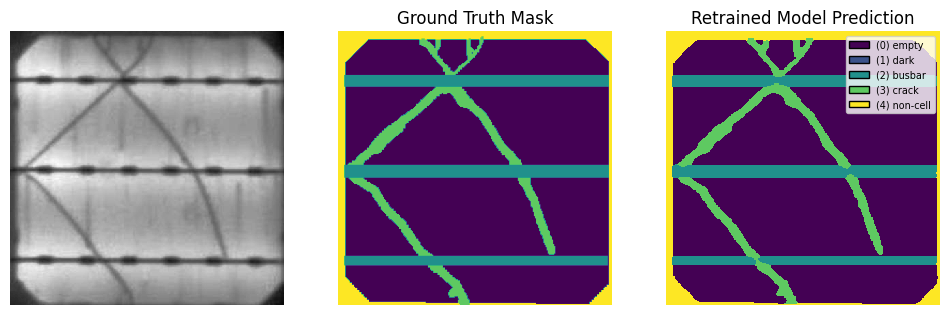

In [13]:
inference_and_show(-32, retrained=True)

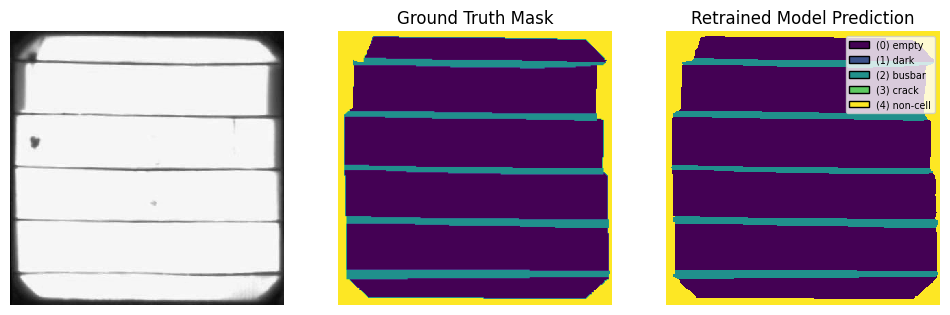

In [14]:
inference_and_show(13, retrained=True)

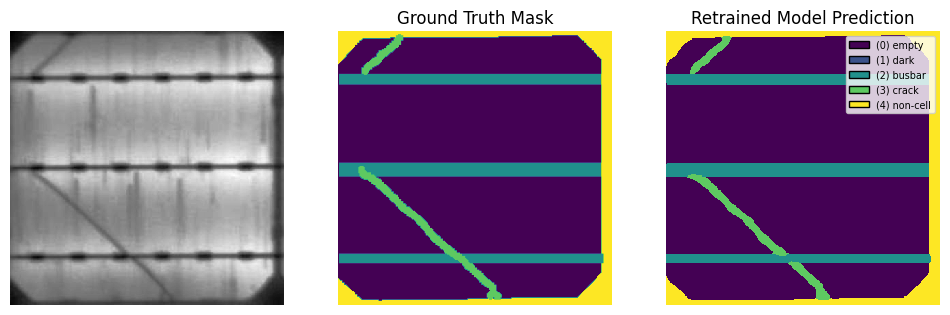

In [15]:
inference_and_show(44, retrained=True)

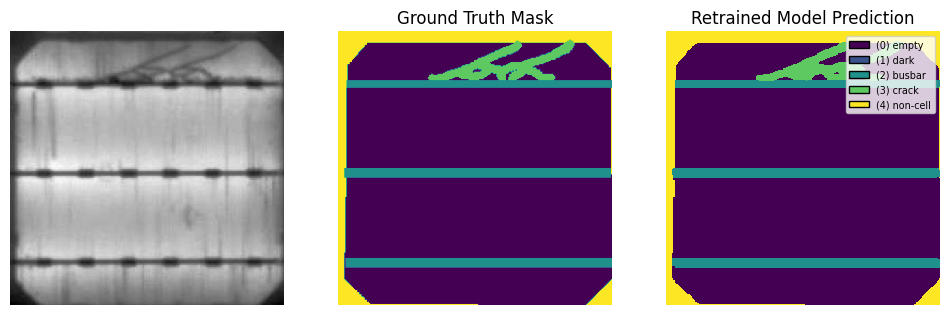

In [16]:
inference_and_show(1, retrained=True)

[np.float64(0.09745327971907922), np.float64(0.07510391510162949), np.float64(0.06736948155807425), np.float64(0.06148016262358702), np.float64(0.05627603827428723), np.float64(0.051635473513704275), np.float64(0.04734618671259925), np.float64(0.043324073794073444), np.float64(0.03955023038412026), np.float64(0.036039581409457955), np.float64(0.0327893338746742), np.float64(0.02978947146729839), np.float64(0.027020957752320416), np.float64(0.024461005658481114), np.float64(0.022113512989810923), np.float64(0.01996227182396842), np.float64(0.01799452401735265), np.float64(0.01620127338127194), np.float64(0.01458596295884086), np.float64(0.013137472749111197), np.float64(0.01184719051086595), np.float64(0.010689370498440159), np.float64(0.009662020017163127), np.float64(0.008746170589846827), np.float64(0.007933512296961704), np.float64(0.007206647613349211), np.float64(0.006560821456412689), np.float64(0.005989936022336553), np.float64(0.0054794235780235775), np.float64(0.00502392903446

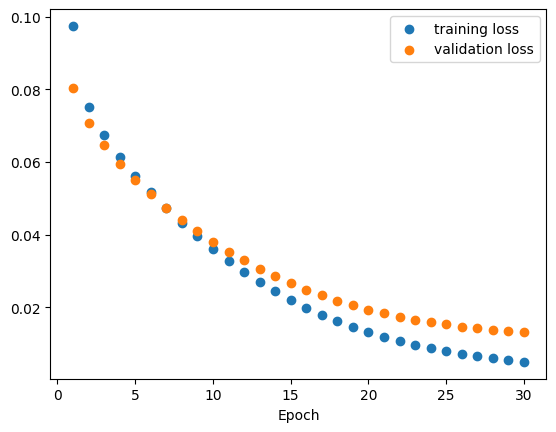

In [17]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [18]:
val_epoch_loss

[np.float64(0.0805089409217174),
 np.float64(0.07073717810278073),
 np.float64(0.06456126959679963),
 np.float64(0.05944129979052456),
 np.float64(0.054993245460383304),
 np.float64(0.051115559829294166),
 np.float64(0.047479409047148445),
 np.float64(0.044088430291452964),
 np.float64(0.040931088531397895),
 np.float64(0.038066887510416314),
 np.float64(0.035396511198799586),
 np.float64(0.032949151090261614),
 np.float64(0.030668063111425864),
 np.float64(0.028573306472931718),
 np.float64(0.026661682484905313),
 np.float64(0.024925427017451235),
 np.float64(0.02332066046880373),
 np.float64(0.021865595331681625),
 np.float64(0.02056423895004572),
 np.float64(0.01941273805838546),
 np.float64(0.018371524224743183),
 np.float64(0.017457531299442053),
 np.float64(0.01661723991452809),
 np.float64(0.015936968661643146),
 np.float64(0.015326519152028607),
 np.float64(0.014754219575345645),
 np.float64(0.01429137619397728),
 np.float64(0.013881952761878053),
 np.float64(0.0134863817643019

# SECOND TRAINING

In [19]:
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_CWRU_SunEdison/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_LBNL/"

# checkpoint_name = "Fresh_Combined_CWRU_LBNL_ASU"
checkpoint_name = "Fresh_CWRU_SunEdison"
# checkpoint_name = "Fresh_ASU"
# checkpoint_name = "Fresh_LBNL"

In [20]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model(weight_path)

In [21]:
batch_size_val = 1
batch_size_train = 1
lr = 0.000001
step_size = 1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.SmoothL1Loss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [22]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [23]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)

        training_loss = criterion(output_activated, target_onehot.float())
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)

        output = model(data)
        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        val_loss = criterion(output_activated, target_onehot.float())

        val_step_loss.append(val_loss.item())

    val_epoch_loss.append(np.array(val_step_loss).mean())

    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    print(f"Saved model at epoch {epoch}")

    if epoch >= 2 and epoch < 30:
        os.remove(os.path.join(save_dir, f"epoch_{epoch - 1}", save_name))
        print(f"Removed model at epoch {epoch - 1}")

  3%|▎         | 1/30 [03:32<1:42:51, 212.81s/it]

Saved model at epoch 1


  7%|▋         | 2/30 [07:06<1:39:31, 213.28s/it]

Saved model at epoch 2
Removed model at epoch 1


 10%|█         | 3/30 [10:40<1:36:05, 213.54s/it]

Saved model at epoch 3
Removed model at epoch 2


 13%|█▎        | 4/30 [14:14<1:32:35, 213.69s/it]

Saved model at epoch 4
Removed model at epoch 3


 17%|█▋        | 5/30 [17:47<1:29:01, 213.65s/it]

Saved model at epoch 5
Removed model at epoch 4


 20%|██        | 6/30 [21:21<1:25:30, 213.75s/it]

Saved model at epoch 6
Removed model at epoch 5


 23%|██▎       | 7/30 [24:54<1:21:46, 213.31s/it]

Saved model at epoch 7
Removed model at epoch 6


 27%|██▋       | 8/30 [28:27<1:18:14, 213.39s/it]

Saved model at epoch 8
Removed model at epoch 7


 30%|███       | 9/30 [32:02<1:14:51, 213.86s/it]

Saved model at epoch 9
Removed model at epoch 8


 33%|███▎      | 10/30 [35:36<1:11:17, 213.86s/it]

Saved model at epoch 10
Removed model at epoch 9


 37%|███▋      | 11/30 [39:09<1:07:39, 213.66s/it]

Saved model at epoch 11
Removed model at epoch 10


 40%|████      | 12/30 [42:42<1:04:04, 213.56s/it]

Saved model at epoch 12
Removed model at epoch 11


 43%|████▎     | 13/30 [46:15<1:00:26, 213.35s/it]

Saved model at epoch 13
Removed model at epoch 12


 47%|████▋     | 14/30 [49:49<56:53, 213.33s/it]  

Saved model at epoch 14
Removed model at epoch 13


 50%|█████     | 15/30 [53:22<53:18, 213.22s/it]

Saved model at epoch 15
Removed model at epoch 14


 53%|█████▎    | 16/30 [56:54<49:41, 212.94s/it]

Saved model at epoch 16
Removed model at epoch 15


 57%|█████▋    | 17/30 [1:00:26<46:06, 212.79s/it]

Saved model at epoch 17
Removed model at epoch 16


 60%|██████    | 18/30 [1:03:59<42:33, 212.76s/it]

Saved model at epoch 18
Removed model at epoch 17


 63%|██████▎   | 19/30 [1:07:31<38:58, 212.56s/it]

Saved model at epoch 19
Removed model at epoch 18


 67%|██████▋   | 20/30 [1:11:03<35:24, 212.41s/it]

Saved model at epoch 20
Removed model at epoch 19


 70%|███████   | 21/30 [1:14:35<31:49, 212.21s/it]

Saved model at epoch 21
Removed model at epoch 20


 73%|███████▎  | 22/30 [1:18:07<28:16, 212.05s/it]

Saved model at epoch 22
Removed model at epoch 21


 77%|███████▋  | 23/30 [1:21:39<24:44, 212.04s/it]

Saved model at epoch 23
Removed model at epoch 22


 80%|████████  | 24/30 [1:25:10<21:10, 211.77s/it]

Saved model at epoch 24
Removed model at epoch 23


 83%|████████▎ | 25/30 [1:28:40<17:36, 211.37s/it]

Saved model at epoch 25
Removed model at epoch 24


 87%|████████▋ | 26/30 [1:32:11<14:05, 211.30s/it]

Saved model at epoch 26
Removed model at epoch 25


 90%|█████████ | 27/30 [1:35:43<10:34, 211.40s/it]

Saved model at epoch 27
Removed model at epoch 26


 93%|█████████▎| 28/30 [1:39:14<07:02, 211.35s/it]

Saved model at epoch 28
Removed model at epoch 27


 97%|█████████▋| 29/30 [1:42:46<03:31, 211.41s/it]

Saved model at epoch 29
Removed model at epoch 28


100%|██████████| 30/30 [1:46:17<00:00, 212.59s/it]

Saved model at epoch 30


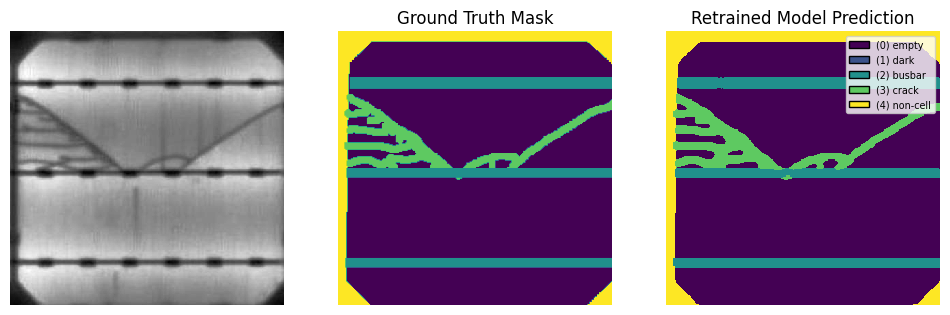

In [24]:
inference_and_show(-32, retrained=True)

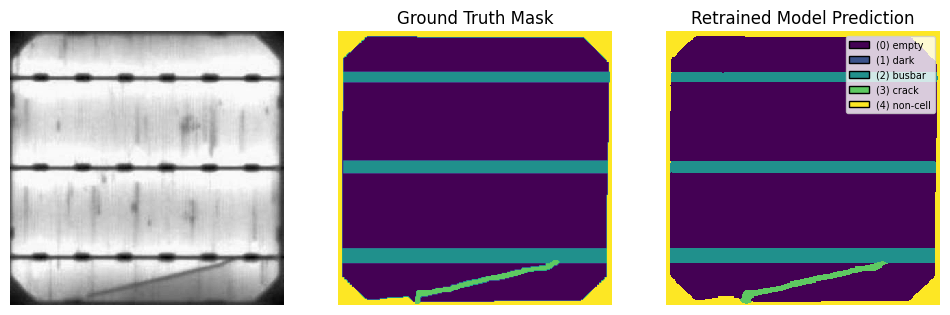

In [25]:
inference_and_show(13, retrained=True)

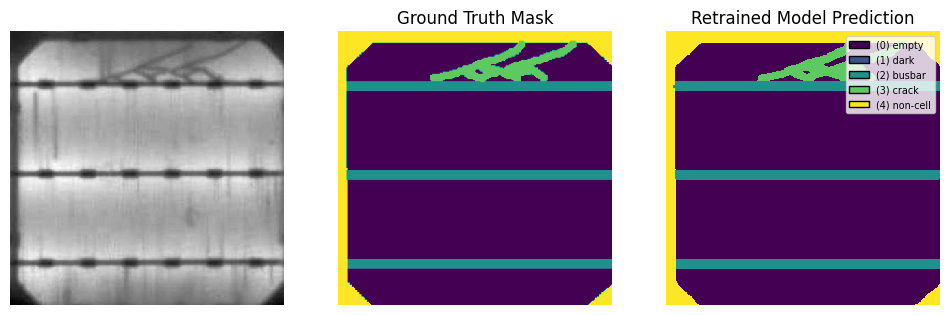

In [26]:
inference_and_show(44, retrained=True)

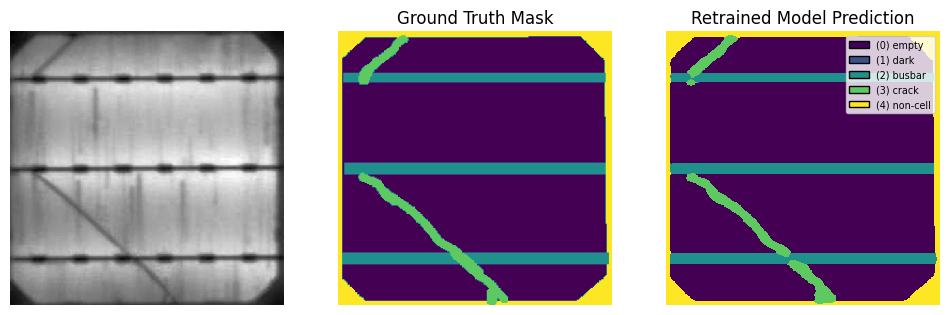

In [27]:
inference_and_show(1, retrained=True)

[np.float64(0.10273502659797669), np.float64(0.07732825532058875), np.float64(0.07105712590118249), np.float64(0.0672294476479292), np.float64(0.0638979581395785), np.float64(0.06085823455452919), np.float64(0.05804876198371251), np.float64(0.05541541122396787), np.float64(0.0530081546207269), np.float64(0.050733721271157266), np.float64(0.04852811857312918), np.float64(0.04634868714710077), np.float64(0.0442038039714098), np.float64(0.04214533387372891), np.float64(0.040180896672109764), np.float64(0.038294712839027245), np.float64(0.03647061266750097), np.float64(0.034703780909379325), np.float64(0.03298948562393586), np.float64(0.031331174679100515), np.float64(0.029736204694956542), np.float64(0.028200354470560948), np.float64(0.0267273732163012), np.float64(0.025290978928407034), np.float64(0.023874561375627917), np.float64(0.022518780082464218), np.float64(0.021238700609654187), np.float64(0.020030370881160102), np.float64(0.0188767549606661), np.float64(0.017774149227887392)]


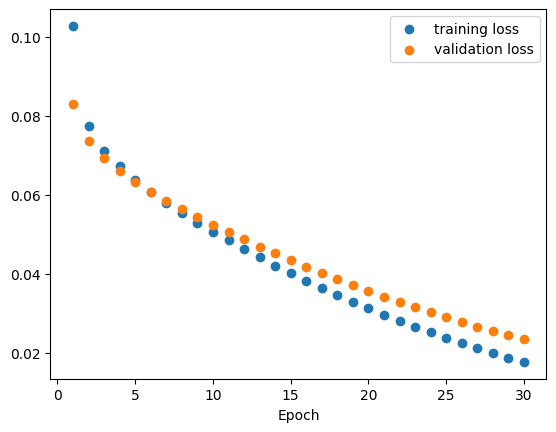

In [28]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [29]:
val_epoch_loss

[np.float64(0.08303728939592839),
 np.float64(0.07352714364230632),
 np.float64(0.06931571216881276),
 np.float64(0.06598514144122601),
 np.float64(0.06316356502473354),
 np.float64(0.06069433601945639),
 np.float64(0.05842689055204391),
 np.float64(0.056324687622487546),
 np.float64(0.054358044490218166),
 np.float64(0.052453905671834944),
 np.float64(0.050602675162255764),
 np.float64(0.04874586182832718),
 np.float64(0.046920421957969666),
 np.float64(0.04519315871596336),
 np.float64(0.043526126138865945),
 np.float64(0.041893008515238764),
 np.float64(0.040321243174374105),
 np.float64(0.03875068929046392),
 np.float64(0.0372179709598422),
 np.float64(0.03573594731837511),
 np.float64(0.03430058739334345),
 np.float64(0.03293975418806076),
 np.float64(0.03158716413751245),
 np.float64(0.03031295754387975),
 np.float64(0.029051520083099604),
 np.float64(0.027816166061908006),
 np.float64(0.026680657852441073),
 np.float64(0.025619024105370043),
 np.float64(0.02456616647541523),
 np

## THIRD TRAINING

In [30]:
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_CWRU_SunEdison/"
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_LBNL/"

# checkpoint_name = "Fresh_Combined_CWRU_LBNL_ASU"
# checkpoint_name = "Fresh_CWRU_SunEdison"
checkpoint_name = "Fresh_ASU"
# checkpoint_name = "Fresh_LBNL"

In [31]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model(weight_path)

In [32]:
batch_size_val = 1
batch_size_train = 1
lr = 0.000001
step_size = 1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.SmoothL1Loss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [33]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [34]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)

        training_loss = criterion(output_activated, target_onehot.float())
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)

        output = model(data)
        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        val_loss = criterion(output_activated, target_onehot.float())

        val_step_loss.append(val_loss.item())

    val_epoch_loss.append(np.array(val_step_loss).mean())

    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    print(f"Saved model at epoch {epoch}")

    if epoch >= 2 and epoch < 30:
        os.remove(os.path.join(save_dir, f"epoch_{epoch - 1}", save_name))
        print(f"Removed model at epoch {epoch - 1}")

  3%|▎         | 1/30 [01:19<38:13, 79.08s/it]

Saved model at epoch 1


  7%|▋         | 2/30 [02:37<36:39, 78.57s/it]

Saved model at epoch 2
Removed model at epoch 1


 10%|█         | 3/30 [03:55<35:18, 78.46s/it]

Saved model at epoch 3
Removed model at epoch 2


 13%|█▎        | 4/30 [05:14<34:00, 78.49s/it]

Saved model at epoch 4
Removed model at epoch 3


 17%|█▋        | 5/30 [06:32<32:39, 78.36s/it]

Saved model at epoch 5
Removed model at epoch 4


 20%|██        | 6/30 [07:50<31:18, 78.27s/it]

Saved model at epoch 6
Removed model at epoch 5


 23%|██▎       | 7/30 [09:08<29:58, 78.21s/it]

Saved model at epoch 7
Removed model at epoch 6


 27%|██▋       | 8/30 [10:26<28:40, 78.22s/it]

Saved model at epoch 8
Removed model at epoch 7


 30%|███       | 9/30 [11:44<27:20, 78.14s/it]

Saved model at epoch 9
Removed model at epoch 8


 33%|███▎      | 10/30 [13:02<26:01, 78.06s/it]

Saved model at epoch 10
Removed model at epoch 9


 37%|███▋      | 11/30 [14:20<24:43, 78.08s/it]

Saved model at epoch 11
Removed model at epoch 10


 40%|████      | 12/30 [15:38<23:25, 78.06s/it]

Saved model at epoch 12
Removed model at epoch 11


 43%|████▎     | 13/30 [16:57<22:08, 78.16s/it]

Saved model at epoch 13
Removed model at epoch 12


 47%|████▋     | 14/30 [18:15<20:52, 78.28s/it]

Saved model at epoch 14
Removed model at epoch 13


 50%|█████     | 15/30 [19:33<19:32, 78.19s/it]

Saved model at epoch 15
Removed model at epoch 14


 53%|█████▎    | 16/30 [20:51<18:14, 78.15s/it]

Saved model at epoch 16
Removed model at epoch 15


 57%|█████▋    | 17/30 [22:09<16:55, 78.11s/it]

Saved model at epoch 17
Removed model at epoch 16


 60%|██████    | 18/30 [23:27<15:36, 78.08s/it]

Saved model at epoch 18
Removed model at epoch 17


 63%|██████▎   | 19/30 [24:46<14:19, 78.18s/it]

Saved model at epoch 19
Removed model at epoch 18


 67%|██████▋   | 20/30 [26:04<13:01, 78.19s/it]

Saved model at epoch 20
Removed model at epoch 19


 70%|███████   | 21/30 [27:22<11:43, 78.22s/it]

Saved model at epoch 21
Removed model at epoch 20


 73%|███████▎  | 22/30 [28:40<10:25, 78.20s/it]

Saved model at epoch 22
Removed model at epoch 21


 77%|███████▋  | 23/30 [29:58<09:07, 78.17s/it]

Saved model at epoch 23
Removed model at epoch 22


 80%|████████  | 24/30 [31:17<07:49, 78.17s/it]

Saved model at epoch 24
Removed model at epoch 23


 83%|████████▎ | 25/30 [32:35<06:30, 78.15s/it]

Saved model at epoch 25
Removed model at epoch 24


 87%|████████▋ | 26/30 [33:53<05:12, 78.09s/it]

Saved model at epoch 26
Removed model at epoch 25


 90%|█████████ | 27/30 [35:11<03:54, 78.13s/it]

Saved model at epoch 27
Removed model at epoch 26


 93%|█████████▎| 28/30 [36:29<02:36, 78.07s/it]

Saved model at epoch 28
Removed model at epoch 27


 97%|█████████▋| 29/30 [37:47<01:18, 78.09s/it]

Saved model at epoch 29
Removed model at epoch 28


100%|██████████| 30/30 [39:05<00:00, 78.18s/it]

Saved model at epoch 30


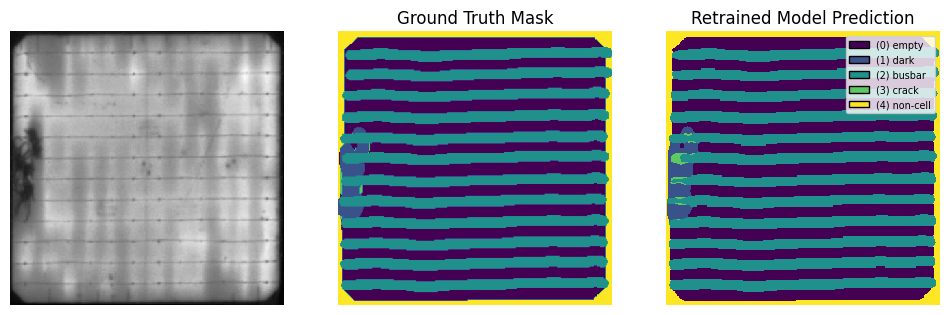

In [35]:
inference_and_show(-32, retrained=True)

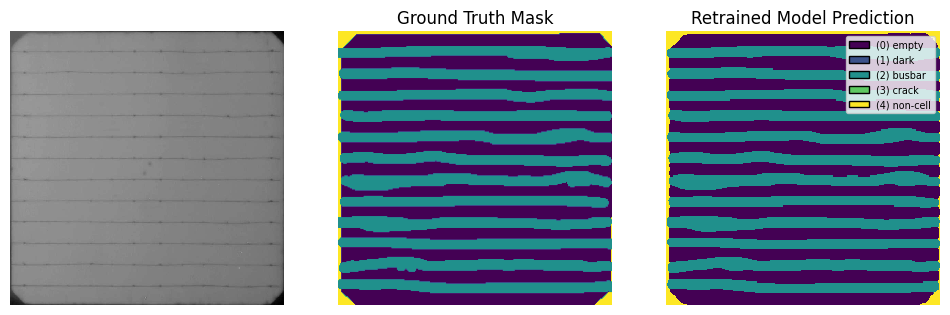

In [36]:
inference_and_show(13, retrained=True)

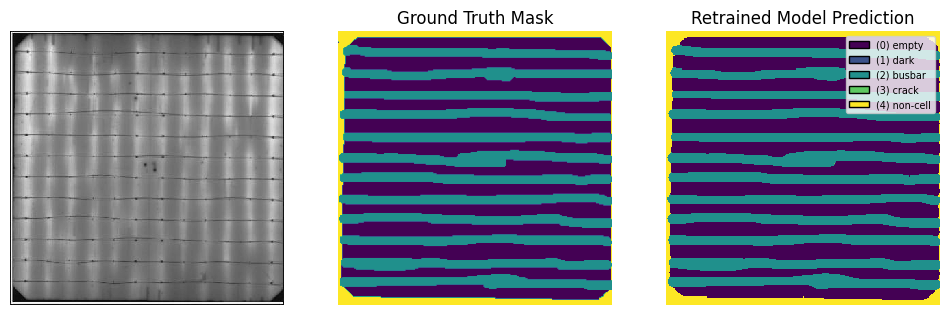

In [37]:
inference_and_show(44, retrained=True)

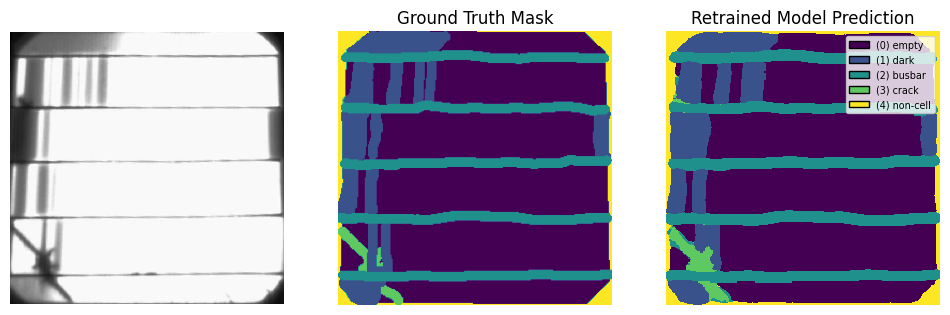

In [38]:
inference_and_show(1, retrained=True)

[np.float64(0.11129742941778639), np.float64(0.09526345797854921), np.float64(0.08691393880956415), np.float64(0.0809096695477332), np.float64(0.07639729177606279), np.float64(0.0730352932182343), np.float64(0.07034172367412543), np.float64(0.06800977669089385), np.float64(0.06596984272228851), np.float64(0.06414492701625694), np.float64(0.062444626961065376), np.float64(0.06084400105654546), np.float64(0.059364829266416855), np.float64(0.05796078222034418), np.float64(0.056636228212627815), np.float64(0.05536464125970784), np.float64(0.05413072052128289), np.float64(0.05293805257457754), np.float64(0.051779558929358274), np.float64(0.050667441524295274), np.float64(0.04958262196674511), np.float64(0.04853942171009122), np.float64(0.04752957254000332), np.float64(0.04656395195996848), np.float64(0.04562096569039251), np.float64(0.04471255730216702), np.float64(0.043819108667472996), np.float64(0.04294832855921941), np.float64(0.04210619348357769), np.float64(0.041281360491732325)]


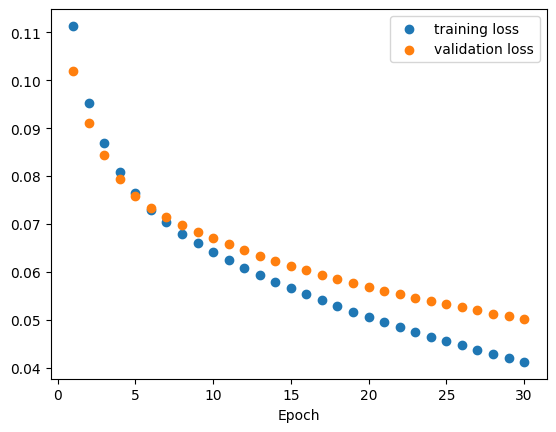

In [39]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [40]:
val_epoch_loss

[np.float64(0.10181474151170772),
 np.float64(0.09106577961179226),
 np.float64(0.08437636668753365),
 np.float64(0.07941952619053748),
 np.float64(0.07585012904651788),
 np.float64(0.073334241974289),
 np.float64(0.07138010219711324),
 np.float64(0.06979313715482535),
 np.float64(0.06837999650641628),
 np.float64(0.06705071694096146),
 np.float64(0.06576821378067783),
 np.float64(0.06453325973985635),
 np.float64(0.06338038259064374),
 np.float64(0.0623230862269259),
 np.float64(0.061300980089151344),
 np.float64(0.06034355215809267),
 np.float64(0.05940437322968374),
 np.float64(0.058523494466815304),
 np.float64(0.05769754442102883),
 np.float64(0.05691262338634418),
 np.float64(0.056136970246291676),
 np.float64(0.05540541221347192),
 np.float64(0.0546696892656062),
 np.float64(0.05400788379104241),
 np.float64(0.05332707672420403),
 np.float64(0.05266021935107267),
 np.float64(0.05200045266310158),
 np.float64(0.05136651553861473),
 np.float64(0.050757900265085955),
 np.float64(0.

## FOURTH TRAINING

In [41]:
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_Combined_CWRU_LBNL_ASU/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_CWRU_SunEdison/"
# root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_ASU/"
root = "/Users/ojas/Desktop/saj/SANDIA/pvcracks_data/Fresh_LBNL/"

# checkpoint_name = "Fresh_Combined_CWRU_LBNL_ASU"
# checkpoint_name = "Fresh_CWRU_SunEdison"
# checkpoint_name = "Fresh_ASU"
checkpoint_name = "Fresh_LBNL"

In [42]:
train_dataset, val_dataset = load_dataset(root)
device, model = load_device_and_model(weight_path)

In [43]:
batch_size_val = 1
batch_size_train = 1
lr = 0.000001
step_size = 1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.SmoothL1Loss()

save_dir = get_save_dir(str(root), checkpoint_name)
os.makedirs(save_dir, exist_ok=True)

params_dict = {
    "batch_size_val": batch_size_val,
    "batch_size_train": batch_size_train,
    "lr": lr,
    "step_size": step_size,
    "gamma": gamma,
    "num_epochs": num_epochs,
    "criterion": str(criterion),
}

with open(os.path.join(save_dir, "params.json"), "w", encoding="utf-8") as f:
    json.dump(params_dict, f, ensure_ascii=False, indent=4)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)

In [44]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric = None
running_record = {"train": {"loss": []}, "val": {"loss": []}}

save_name = "model.pt"
cache_output = True

In [45]:
training_epoch_loss = []
val_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    training_step_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)

        training_loss = criterion(output_activated, target_onehot.float())
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())

    training_epoch_loss.append(np.array(training_step_loss).mean())

    val_step_loss = []

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)

        output = model(data)
        output_activated = 1 / (1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes=5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        val_loss = criterion(output_activated, target_onehot.float())

        val_step_loss.append(val_loss.item())

    val_epoch_loss.append(np.array(val_step_loss).mean())

    os.makedirs(os.path.join(save_dir, f"epoch_{epoch}"), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch}", save_name))
    print(f"Saved model at epoch {epoch}")

    if epoch >= 2 and epoch < 30:
        os.remove(os.path.join(save_dir, f"epoch_{epoch - 1}", save_name))
        print(f"Removed model at epoch {epoch - 1}")

  3%|▎         | 1/30 [01:40<48:32, 100.43s/it]

Saved model at epoch 1


  7%|▋         | 2/30 [03:20<46:52, 100.44s/it]

Saved model at epoch 2
Removed model at epoch 1


 10%|█         | 3/30 [05:01<45:11, 100.41s/it]

Saved model at epoch 3
Removed model at epoch 2


 13%|█▎        | 4/30 [06:42<43:37, 100.66s/it]

Saved model at epoch 4
Removed model at epoch 3


 17%|█▋        | 5/30 [08:22<41:55, 100.60s/it]

Saved model at epoch 5
Removed model at epoch 4


 20%|██        | 6/30 [10:03<40:12, 100.53s/it]

Saved model at epoch 6
Removed model at epoch 5


 23%|██▎       | 7/30 [11:43<38:31, 100.49s/it]

Saved model at epoch 7
Removed model at epoch 6


 27%|██▋       | 8/30 [13:23<36:49, 100.45s/it]

Saved model at epoch 8
Removed model at epoch 7


 30%|███       | 9/30 [15:04<35:09, 100.45s/it]

Saved model at epoch 9
Removed model at epoch 8


 33%|███▎      | 10/30 [16:45<33:30, 100.53s/it]

Saved model at epoch 10
Removed model at epoch 9


 37%|███▋      | 11/30 [18:25<31:48, 100.43s/it]

Saved model at epoch 11
Removed model at epoch 10


 40%|████      | 12/30 [20:05<30:06, 100.37s/it]

Saved model at epoch 12
Removed model at epoch 11


 43%|████▎     | 13/30 [21:45<28:25, 100.34s/it]

Saved model at epoch 13
Removed model at epoch 12


 47%|████▋     | 14/30 [23:26<26:44, 100.30s/it]

Saved model at epoch 14
Removed model at epoch 13


 50%|█████     | 15/30 [25:06<25:04, 100.32s/it]

Saved model at epoch 15
Removed model at epoch 14


 53%|█████▎    | 16/30 [26:47<23:26, 100.45s/it]

Saved model at epoch 16
Removed model at epoch 15


 57%|█████▋    | 17/30 [28:27<21:45, 100.42s/it]

Saved model at epoch 17
Removed model at epoch 16


 60%|██████    | 18/30 [30:08<20:06, 100.55s/it]

Saved model at epoch 18
Removed model at epoch 17


 63%|██████▎   | 19/30 [31:49<18:26, 100.59s/it]

Saved model at epoch 19
Removed model at epoch 18


 67%|██████▋   | 20/30 [33:29<16:45, 100.55s/it]

Saved model at epoch 20
Removed model at epoch 19


 70%|███████   | 21/30 [35:10<15:05, 100.57s/it]

Saved model at epoch 21
Removed model at epoch 20


 73%|███████▎  | 22/30 [36:50<13:24, 100.56s/it]

Saved model at epoch 22
Removed model at epoch 21


 77%|███████▋  | 23/30 [38:30<11:43, 100.48s/it]

Saved model at epoch 23
Removed model at epoch 22


 80%|████████  | 24/30 [40:13<10:05, 100.99s/it]

Saved model at epoch 24
Removed model at epoch 23


 83%|████████▎ | 25/30 [41:55<08:27, 101.48s/it]

Saved model at epoch 25
Removed model at epoch 24


 87%|████████▋ | 26/30 [43:37<06:46, 101.66s/it]

Saved model at epoch 26
Removed model at epoch 25


 90%|█████████ | 27/30 [45:19<05:04, 101.53s/it]

Saved model at epoch 27
Removed model at epoch 26


 93%|█████████▎| 28/30 [46:59<03:22, 101.24s/it]

Saved model at epoch 28
Removed model at epoch 27


 97%|█████████▋| 29/30 [48:40<01:41, 101.05s/it]

Saved model at epoch 29
Removed model at epoch 28


100%|██████████| 30/30 [50:20<00:00, 100.69s/it]

Saved model at epoch 30


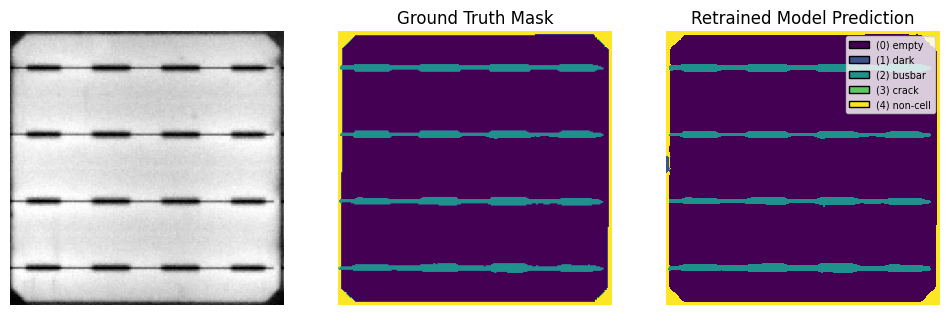

In [46]:
inference_and_show(-32, retrained=True)

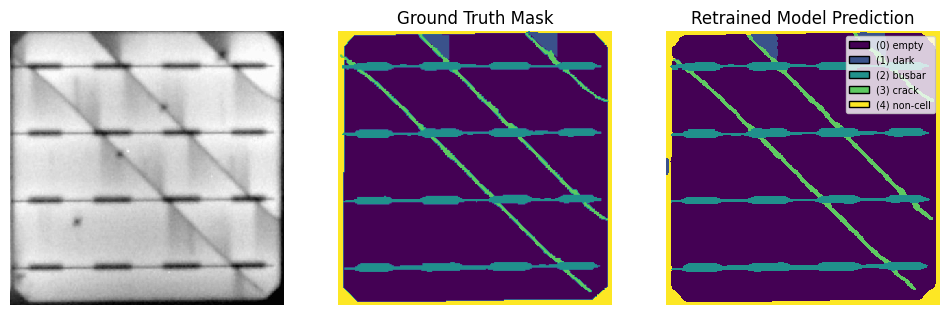

In [47]:
inference_and_show(13, retrained=True)

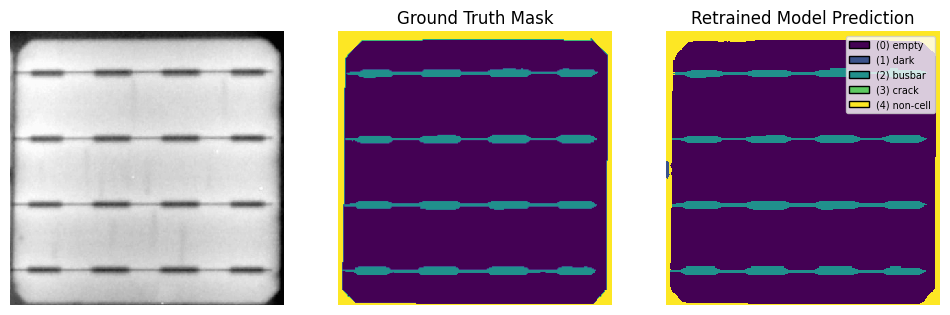

In [48]:
inference_and_show(44, retrained=True)

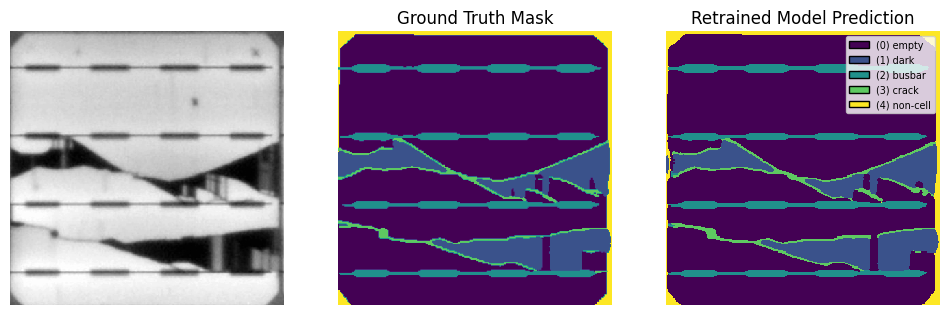

In [49]:
inference_and_show(1, retrained=True)

[np.float64(0.12427664428121514), np.float64(0.10245991563424468), np.float64(0.09367337880863083), np.float64(0.08888517867566811), np.float64(0.0852935115289357), np.float64(0.08243415884466634), np.float64(0.08025741298786468), np.float64(0.07838364478407635), np.float64(0.07667637579143047), np.float64(0.07506601087128123), np.float64(0.07354245344176888), np.float64(0.07206269494361348), np.float64(0.07062477241787646), np.float64(0.06921637297297517), np.float64(0.06784987922550903), np.float64(0.06649435350878372), np.float64(0.06515825550175375), np.float64(0.06385795999732283), np.float64(0.06260337701274289), np.float64(0.061368770411031115), np.float64(0.06016930152869059), np.float64(0.05898107751272619), np.float64(0.05779548887577322), np.float64(0.056638080233501066), np.float64(0.05550167061285012), np.float64(0.054380086716264486), np.float64(0.05326801537950006), np.float64(0.05216351860306329), np.float64(0.051048039484562144), np.float64(0.049873194745224385)]


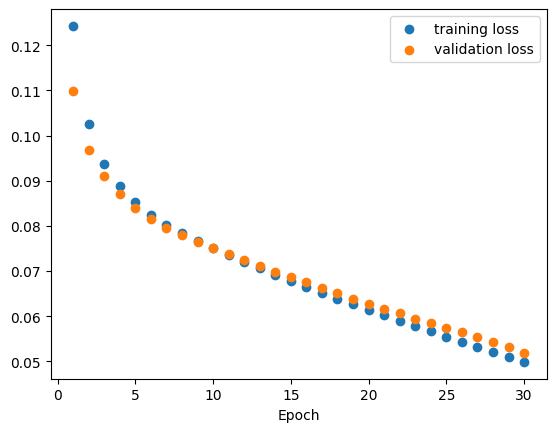

In [50]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label="training loss")
ax.scatter(x, val_epoch_loss, label="validation loss")
ax.legend()
ax.set_xlabel("Epoch")

print(training_epoch_loss)

In [51]:
val_epoch_loss

[np.float64(0.10987754150604208),
 np.float64(0.09687932739034295),
 np.float64(0.09111347555493315),
 np.float64(0.0870635296838979),
 np.float64(0.08384880237281322),
 np.float64(0.08151536860192815),
 np.float64(0.07963359178975224),
 np.float64(0.0779394463635981),
 np.float64(0.07649200484156608),
 np.float64(0.07513091921185454),
 np.float64(0.0737023375928402),
 np.float64(0.07235826648150881),
 np.float64(0.07114486855765184),
 np.float64(0.06985967388997476),
 np.float64(0.0687023309369882),
 np.float64(0.06751591423526407),
 np.float64(0.06631112213556965),
 np.float64(0.06514084134250879),
 np.float64(0.06389407288903991),
 np.float64(0.06267505874857307),
 np.float64(0.06170279715831081),
 np.float64(0.06063500347857674),
 np.float64(0.05946441193421682),
 np.float64(0.058459672642250854),
 np.float64(0.05733830987786253),
 np.float64(0.05640385209893187),
 np.float64(0.05528792484352986),
 np.float64(0.054187397255251804),
 np.float64(0.05307105160318315),
 np.float64(0.05